In [1]:
from sklearn.datasets import fetch_openml # load MNIST data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math # for exp in sigmoid

# 1. Load MNIST Dataset
<img src='media/MNIST_examples.png' alt='MNIST examples'>

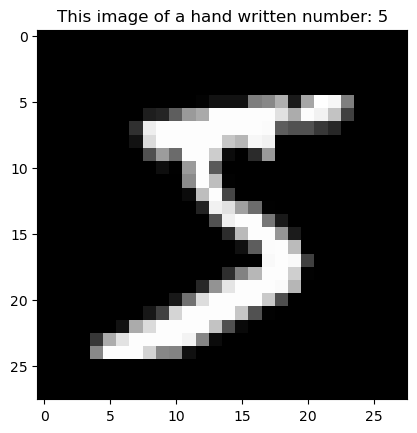

In [62]:
# load data from sklearn
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target'] # two dataframes
y_one_hot_array = pd.get_dummies(y, prefix='class').to_numpy().astype(int)
# plot first example
image = X.iloc[0].values.reshape(28, 28)
label = y.iloc[0]
plt.title(f'This image of a hand written number: {label}')
plt.imshow(image, cmap='gray')

# 2. Activation Functions

In [19]:
def ReLU(x):
    # rectified linear unit
    return np.maximum(0, x)

def SELU(x):
    # scaled exponential linear unit
    return np.where(x <= 0, 1.75809 * (np.exp(x)-1), 1.0507 * x)

def tanh(x):
    # hyperbolic tangent
    x = np.clip(x, -500, 500)  # prevent overflow
    exp_x = np.exp(x)
    exp_neg_x = np.exp(-x)
    return (exp_x - exp_neg_x) / (exp_x + exp_neg_x)


def softmax(x):
    denominator = np.sum(np.exp(x)) # sum of all the e^logit for every logit
    return np.exp(x) / denominator # normalize e^logit value by sum of e^logits


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# 3. Initialize Numpy Neural Network
<img src='media/nn_arcitecture.png' alt='Network Arcitecture'>

## Weight Initializations

In [4]:
def xavier_init(size):
    in_dim, out_dim = size
    limit = np.sqrt(6 / (in_dim + out_dim))
    return np.random.uniform(-limit, limit, size)


def he_init(size):
    in_dim, _ = size
    stddev = np.sqrt(2 / in_dim)
    return np.random.normal(0, stddev, size)

In [5]:
X.iloc[0].values.shape

(784,)

In [36]:
x = X.iloc[0].values / 255 # normalize it
input_size = X.iloc[0].values.shape[0]
output_size = len(y.values.unique())

#### Initialize weight matrixes

# first layer of model
l1_num_nodes = 1568
l1_weights = np.random.randn(input_size, l1_num_nodes)
l1_output = np.dot(x, l1_weights) # you would just add a bias term to this
print(f'shape of layer 1 rep: {l1_output.shape}')
# second layer of the model
l2_num_nodes = 2000
l2_weights = np.random.randn(l1_num_nodes, l2_num_nodes)
l2_output = np.dot(l1_output, l2_weights) # you would just add a bias term to this
print(f'shape of layer 2 rep: {l2_output.shape}')

# Third layer
l3_num_nodes = 784
l3_weights = np.random.randn(l2_num_nodes, l3_num_nodes)
l3_output = np.dot(l2_output, l3_weights) # you would just add a bias term to this
print(f'shape of layer 3 rep: {l3_output.shape}')

# Final output layer
l4_num_nodes = output_size
l4_weights = np.random.randn(l3_num_nodes, l4_num_nodes)
l4_output = np.dot(l3_output, l4_weights) # you would just add a bias term to this
print(f'output shape: {l4_output.shape}')

shape of layer 1 rep: (1568,)
shape of layer 2 rep: (2000,)
shape of layer 3 rep: (784,)
output shape: (10,)


In [183]:
from linearnn import linearnnclasses
linearlayer = linearnnclasses.LinearLayer(
    input_size=784, 
    output_size=1568, 
    activation_fn_class=ReLU, 
    weight_init=he_init
)

print(linearlayer)
linearlayer.forward(x)

LinearLayer input:784, output:1568, activation:<class 'linearnn.activationfunctions.ReLU'>


array([0.75272997, 0.69611051, 0.30338067, ..., 0.        , 0.        ,
       0.        ])

In [125]:
ReLU().forward([-10, 6])

array([0, 6])

In [144]:
x_batch = X.iloc[0:100].values / 255
print(x_batch.shape)

(100, 784)


In [200]:
from linearnn import linearnnclasses
from linearnn.activationfunctions import ReLU, SELU, Tanh, Softmax
# from linearnn.optim import AdamOptimizer
from linearnn import optim
import importlib
importlib.reload(linearnnclasses)
importlib.reload(optim)

class CategoricalCrossEntropy:
    def forward(self, y:np.array, y_hat:np.array):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15) # There should be no zeros but if there will that would cause a bug
        batch_size = y.shape[0]
        return -np.sum(y * np.log(y_hat)) / batch_size
    
    def derivative(self, y:np.array, y_hat:np.array):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        batch_size = y.shape[0]
        return -(y / y_hat) / batch_size



sequential_model = linearnnclasses.SequentialModel(
    input_size=784,
    output_size=10,
    hidden_layers=(1568, 2000, 784), 
    activation_fn_classes=(ReLU, ReLU, SELU, Tanh, Softmax),
    weight_init=(he_init, he_init, he_init, xavier_init, he_init),
    loss_fn_class = CategoricalCrossEntropy,
    optimizer=None#optim.AdamOptimizer() # with default settings (see linearnn/optim.py)
)
# sequential_model.forward(x_batch)
# sequential_model.backward(x_batch, y_one_hot_array[0:100, :])

building model...
Adding: LinearLayer input:784, output:1568, activation:<class 'linearnn.activationfunctions.ReLU'>
Adding: LinearLayer input:1568, output:2000, activation:<class 'linearnn.activationfunctions.SELU'>
Adding: LinearLayer input:2000, output:784, activation:<class 'linearnn.activationfunctions.Tanh'>
Adding: LinearLayer input:784, output:10, activation:<class 'linearnn.activationfunctions.Softmax'>
model built


# 4. Model Training

In [201]:
num_epochs = 10
batch_size = 100

for epoch in range(num_epochs):
    # itterate over batches
    running_loss = 0.0
    for i in range(0, X.iloc[0:6000].shape[0]-batch_size, batch_size):
        x_batch = X.iloc[i:i+batch_size].values / 255
        y_batch = y_one_hot_array[i:i+batch_size, :]
        # print(np.unique(x_batch))
        loss = sequential_model.backward(x_batch, y_batch) # forward pass is incorperated in backward function
        # print(x_batch.shape)
        # print(y_batch.shape)
        print(loss)
        if loss == np.nan: print(1/0)
        # break
        running_loss += loss
    # break

    print(running_loss/(X.shape[0]/batch_size))


Max gradient: 0.048529160755109865
Min gradient: -0.048913685209084255
Max gradient: 0.007877850955769695
Min gradient: -0.007091690649685383
Max gradient: 0.01136109658755427
Min gradient: -0.010268274635989009
Max gradient: 0.011985214557774595
Min gradient: -0.010748977058051884
6.977051981676792
Max gradient: 0.053015988405681294
Min gradient: -0.051115488130993994
Max gradient: 0.006936919552583106
Min gradient: -0.007684659373315362
Max gradient: 0.013232669893426197
Min gradient: -0.014124898120043354
Max gradient: 0.012233309807432181
Min gradient: -0.009347187555306946
7.057190306436499
Max gradient: 0.04737667672864737
Min gradient: -0.04558890572977015
Max gradient: 0.007907881555967711
Min gradient: -0.0071877864659974765
Max gradient: 0.009081784742516636
Min gradient: -0.008896840303747836
Max gradient: 0.011740480759841397
Min gradient: -0.011066016974636227
7.054916222495235
Max gradient: 0.061035570764767795
Min gradient: -0.05881382489373984
Max gradient: 0.0078634586

In [203]:
X[-100:-1].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [204]:
sequential_model.forward(X[-100:-1].values)

array([[6.47270833e-04, 1.20335495e-03, 4.71314569e-04, 9.63963017e-06,
        1.63780557e-04, 2.14284716e-04, 1.09416207e-03, 1.79658361e-03,
        7.80375060e-04, 3.47649884e-04],
       [1.44683691e-03, 3.57599521e-03, 5.52994224e-04, 1.26020760e-05,
        1.15229874e-04, 2.33323516e-04, 8.94178440e-04, 3.89799170e-03,
        1.21074585e-03, 7.85173846e-04],
       [6.69781935e-04, 1.46887859e-03, 1.90818961e-04, 1.28413417e-05,
        2.46533744e-04, 7.43945306e-04, 1.56478451e-03, 6.41815817e-03,
        1.93278317e-03, 2.12283421e-03],
       [8.14411439e-04, 1.32288303e-03, 1.50553048e-03, 6.45072496e-05,
        1.98242102e-04, 5.40961983e-04, 5.66691932e-05, 3.73418711e-03,
        1.67115069e-03, 2.16337452e-03],
       [1.33794918e-03, 1.31124284e-03, 8.45627623e-04, 2.39118161e-05,
        2.81907811e-04, 4.38026673e-04, 2.07513914e-03, 7.75891116e-03,
        3.96410900e-04, 3.14848725e-03],
       [1.21248069e-03, 2.57643322e-03, 1.13933109e-03, 1.23479203e-04,
   